# 스팸 메일 분류하기

### 1. 스팸 메일 데이터에 대한 이해

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [4]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   int64 
 1   v2      5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


In [36]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [37]:
print('v2열의 유니크한 값 :',data['v2'].nunique())

v2열의 유니크한 값 : 5169


In [38]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


In [55]:
v1_0_data = data[data['v1'] == 0]

# 데이터를 여러 개의 테이블로 나누기 위해 샘플링
# replace=False로 지정하여 같은 데이터를 중복해서 선택하지 않도록 설정합니다.
num_tables = 6
table_size = len(v1_0_data) // num_tables
tables = [v1_0_data.sample(n=table_size, replace=False) for _ in range(num_tables)]

# 나머지 데이터를 하나의 테이블로 만들기
v1_1_data = data[data['v1'] == 1]

# 만들어진 테이블 출력 또는 파일로 저장
for idx, table in enumerate(tables):
    table.to_csv(f'v1_0_table_{idx+1}.csv', index=False)

v1_1_data.to_csv('v1_1_table.csv', index=False)

In [60]:
# v1_0_table_1.csv와 v1_1_table.csv 파일을 읽어옵니다.
table_1 = pd.read_csv('v1_0_table_1.csv')
table_2 = pd.read_csv('v1_0_table_2.csv')
table_3 = pd.read_csv('v1_0_table_3.csv')
table_4 = pd.read_csv('v1_0_table_4.csv')
table_5 = pd.read_csv('v1_0_table_5.csv')
table_6 = pd.read_csv('v1_0_table_6.csv')
table_v1_1 = pd.read_csv('v1_1_table.csv')

# 두 데이터프레임을 합쳐서 data1 데이터프레임을 생성합니다.
data1 = pd.concat([table_1, table_v1_1], ignore_index=True)
data2 = pd.concat([table_2, table_v1_1], ignore_index=True)
data3 = pd.concat([table_3, table_v1_1], ignore_index=True)
data4 = pd.concat([table_4, table_v1_1], ignore_index=True)
data5 = pd.concat([table_5, table_v1_1], ignore_index=True)
data6 = pd.concat([table_6, table_v1_1], ignore_index=True)

data = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

<Axes: xlabel='v1'>

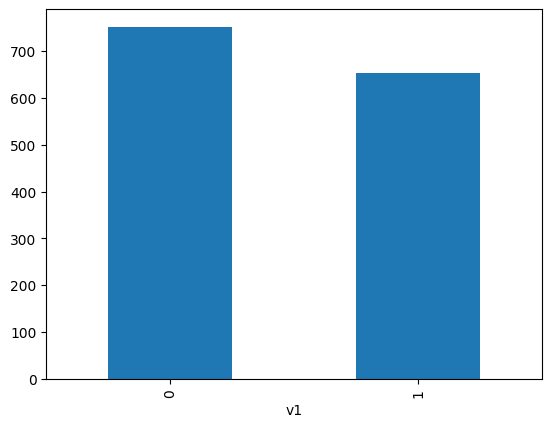

In [58]:
data1['v1'].value_counts().plot(kind='bar')

<Axes: xlabel='v1'>

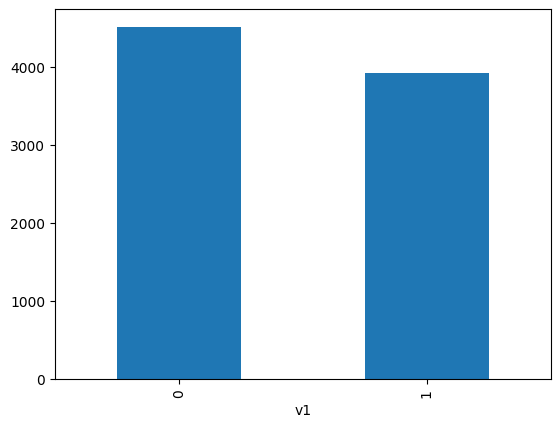

In [61]:
data['v1'].value_counts().plot(kind='bar')

In [62]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4512
1   1   3918


In [59]:
print('정상 메일과 스팸 메일의 개수')
print(data2.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0    752
1   1    653


In [63]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100,3)}%')

정상 메일의 비율 = 53.523%
스팸 메일의 비율 = 46.477%


In [64]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 8430
레이블의 개수: 8430


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [66]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 53.529%
스팸 메일 = 46.471%


In [67]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 53.499%
스팸 메일 = 46.501%


In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[2, 346, 7, 5235, 832, 379, 27, 56], [5236, 3147, 5237, 5238], [154, 1470, 733, 76, 734, 1, 735, 28, 10, 44, 357, 201, 1, 74, 8, 24, 107, 1, 298, 60, 861, 358, 359, 314, 447, 555, 1086], [57, 1150, 1471, 801, 3148, 862, 972, 11, 1270, 1364, 448, 22], [1365, 19, 693, 388, 672, 12, 8, 85, 99, 2053, 12, 28, 99, 449, 12, 1271, 20, 127, 2054, 135, 43, 8, 1271, 2055, 29, 1748, 1, 2056, 136, 556, 242]]


In [69]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'to': 1, 'you': 2, 'a': 3, 'i': 4, 'the': 5, 'call': 6, 'your': 7, 'u': 8, 'for': 9, 'is': 10, 'and': 11, '2': 12, 'now': 13, 'free': 14, 'in': 15, 'or': 16, 'on': 17, 'have': 18, 'of': 19, 'ur': 20, 'from': 21, 'me': 22, '4': 23, 'txt': 24, 'with': 25, 'are': 26, 'it': 27, 'this': 28, 'text': 29, 'get': 30, 'stop': 31, 'mobile': 32, 'my': 33, 'just': 34, 'no': 35, 'reply': 36, 'that': 37, 'be': 38, 'will': 39, 'claim': 40, 'only': 41, 'we': 42, 'can': 43, 'our': 44, 'not': 45, 'so': 46, 'www': 47, 'out': 48, 'at': 49, 'send': 50, 'prize': 51, 'do': 52, 'if': 53, 'new': 54, 'but': 55, 'up': 56, "i'm": 57, 'cash': 58, 'go': 59, '150p': 60, 'please': 61, 'all': 62, 'msg': 63, 't': 64, 'won': 65, 'phone': 66, 'nokia': 67, '1': 68, 'urgent': 69, 'by': 70, 'want': 71, 'uk': 72, 'service': 73, 'contact': 74, 'know': 75, 'been': 76, 'week': 77, 'win': 78, 'how': 79, 'ok': 80, 'like': 81, 'when': 82, 'what': 83, 'good': 84, 'who': 85, 'com': 86, 'day': 87, 'time': 88, 'tone': 89, 'then': 90, 

In [71]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 1832
단어 집합(vocabulary)에서 희귀 단어의 비율: 25.926974242853102
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4257586016358867


In [72]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7067


메일의 최대 길이 : 115
메일의 평균 길이 : 19.052936


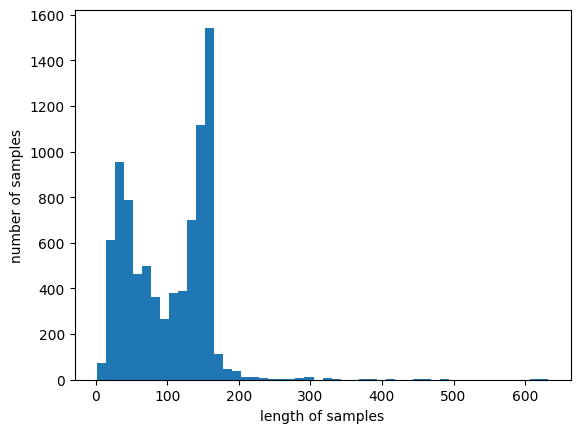

In [73]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [74]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (6744, 189)


In [81]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=6, batch_size=64, validation_split=0.2)

Epoch 1/6
85/85 [==============================] - 2s 16ms/step - loss: 0.3571 - acc: 0.8749 - val_loss: 0.1413 - val_acc: 0.9666
Epoch 2/6
85/85 [==============================] - 1s 15ms/step - loss: 0.1386 - acc: 0.9544 - val_loss: 0.0667 - val_acc: 0.9837
Epoch 3/6
85/85 [==============================] - 1s 15ms/step - loss: 0.1363 - acc: 0.9492 - val_loss: 0.2510 - val_acc: 0.8858
Epoch 4/6
85/85 [==============================] - 1s 15ms/step - loss: 0.1147 - acc: 0.9564 - val_loss: 0.0289 - val_acc: 0.9948
Epoch 5/6
85/85 [==============================] - 1s 15ms/step - loss: 0.0458 - acc: 0.9850 - val_loss: 0.0175 - val_acc: 0.9963
Epoch 6/6
85/85 [==============================] - 1s 15ms/step - loss: 0.0121 - acc: 0.9974 - val_loss: 0.0117 - val_acc: 0.9963


In [82]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

53/53 [==============================] - 0s 3ms/step - loss: 0.0122 - acc: 0.9958

 테스트 정확도: 0.9958


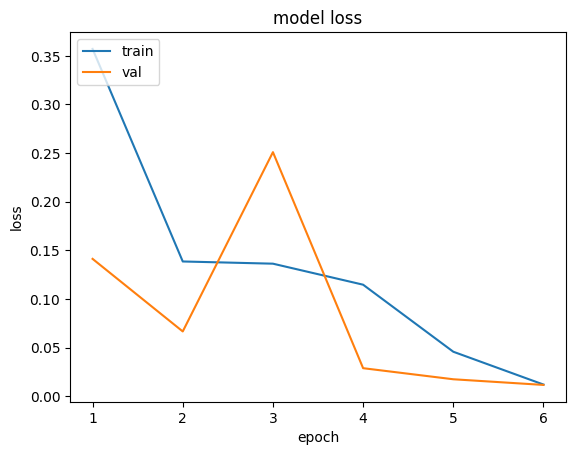

In [83]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()